In [3]:
import os

characterSet = [letters for image in os.listdir('cropped_images') for letters in image[:-4].lower()]
characterSet.append('/')
characterSet = set(characterSet)

with open('letters.txt', 'w') as f:
    for letter in sorted(characterSet):
        f.write(letter + '\n')

In [4]:
char2label = {char : i+1 for i, char in enumerate(list(sorted(characterSet)))} # 0 represents a blank for the CTCloss later
label2char = {i : char for char, i in char2label.items()}

print(f'label2char: \n{label2char}')

label2char: 
{1: '!', 2: '"', 3: '&', 4: "'", 5: '(', 6: ')', 7: '-', 8: '.', 9: '/', 10: '0', 11: '1', 12: '2', 13: '3', 14: '4', 15: '5', 16: '6', 17: '7', 18: '8', 19: '9', 20: ':', 21: '?', 22: '@', 23: 'a', 24: 'b', 25: 'c', 26: 'd', 27: 'e', 28: 'f', 29: 'g', 30: 'h', 31: 'i', 32: 'j', 33: 'k', 34: 'l', 35: 'm', 36: 'n', 37: 'o', 38: 'p', 39: 'q', 40: 'r', 41: 's', 42: 't', 43: 'u', 44: 'v', 45: 'w', 46: 'x', 47: 'y', 48: 'z', 49: '{', 50: '}'}


In [5]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from torchvision.io import read_image
import matplotlib.pyplot as plt
from PIL import Image
class CustomImageDataset(Dataset):

  def __init__(self, img_dir, transform=None):
    self.img_path = []
    self.labels = []
    for f in os.listdir(img_dir):
      # img_dir here only consists of jpg files named with each label
      label = f[:-4].lower().replace('{slash}','/')
      self.labels.append(label)
      self.img_path.append(os.path.join(img_dir, f))
      
    # "During training, all images are scaled to 100 x 32 in order to accelerate the training process."
    self.transform = T.Compose([
        T.Resize((32,100)),
        # Input: W x 32 gray-scale image
        T.Grayscale(),
        T.ToTensor()
    ])

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):

    image = Image.open(self.img_path[idx])
    label_char = self.labels[idx]
    label = [char2label[l] for l in label_char]

    if self.transform:
      image = self.transform(image)

    return image, torch.LongTensor(label), torch.LongTensor([len(label)]) 

In [6]:
customdata = CustomImageDataset("cropped_images")
print(len(customdata))
img_0, img_0_label, img_0_label_len = customdata[0]
print(f'img_0.shape: {img_0.shape}')
print(f'img_0_label: {img_0_label}')
print(''.join(label2char[l.item()] for l in img_0_label))

560
img_0.shape: torch.Size([1, 32, 100])
img_0_label: tensor([45, 45, 45,  8, 41, 27, 40, 44, 31, 38, 34, 43, 41,  8, 26, 27])
www.serviplus.de


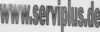

In [7]:
# img_0
to_pil = T.ToPILImage()
img = to_pil(img_0)
img 

https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

### Train (80%) Test (20%) Split

In [8]:
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 16
test_split = .2
shuffle_dataset = True
random_seed = 42

dataset_size = len(customdata)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset:
  np.random.seed(random_seed)
  np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

In the context of PyTorch's DataLoader, batch is a list of tuples like [datasetClass[0], datasetClass[1], ...]
* [(img_0, img_0_label, img_0_label_len), (img_1, img_1_label, img_1_label_len), ...]

In [9]:
from torch.nn.utils.rnn import pad_sequence

# A sample batch with batch_size = 3 to see how `pad_sequence` works
sample_batch = [customdata[0], customdata[1], customdata[2]]
imgs, labels, label_lens = zip(*sample_batch)
print(f'labels:\n{labels}')
padded_labels = pad_sequence([label for label in labels], batch_first=True)
print(f'padded_labels:\n{padded_labels}')

labels:
(tensor([45, 45, 45,  8, 41, 27, 40, 44, 31, 38, 34, 43, 41,  8, 26, 27]), tensor([35, 23, 31, 36, 42, 27, 36, 23, 36, 25, 27]), tensor([23, 40, 25, 30, 31, 42, 27, 33, 42]))
padded_labels:
tensor([[45, 45, 45,  8, 41, 27, 40, 44, 31, 38, 34, 43, 41,  8, 26, 27],
        [35, 23, 31, 36, 42, 27, 36, 23, 36, 25, 27,  0,  0,  0,  0,  0],
        [23, 40, 25, 30, 31, 42, 27, 33, 42,  0,  0,  0,  0,  0,  0,  0]])


In [10]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(data):

  imgs, labels, label_lens = zip(*data) # each type is tuple 
  padded_labels = pad_sequence([label for label in labels], batch_first=True)
  
  return torch.stack(imgs), padded_labels, torch.stack(label_lens)

In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(customdata, batch_size=batch_size, sampler=train_sampler, collate_fn = collate_fn)
test_dataloader = DataLoader(customdata, batch_size=batch_size, sampler=test_sampler, collate_fn = collate_fn)

### torch.nn.Conv2d 

`torch.nn.Conv2d` applies 2D convolution changing the input size of $(C_{in}, H_{in}, W_{in})$ to $(C_{out}, H_{out}, W_{out})$

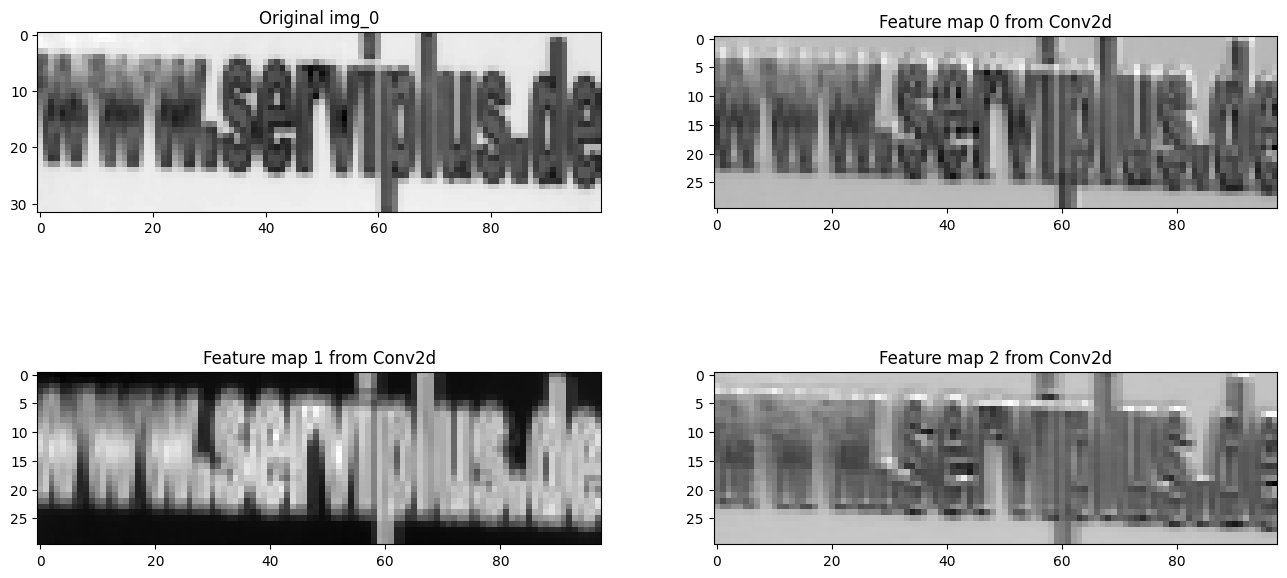

In [18]:
from torch import nn

# img_0.shape: (1, 32, 100) -   m   -> (3, 30, 98)
m = nn.Conv2d(in_channels=img_0.shape[0], out_channels=3, kernel_size=3)

img_p = m(img_0).permute(1,2,0) 
np_img = img_p.detach().numpy()

plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.imshow(img_0[0], cmap='gray')
plt.title('Original img_0')

for i in range(3):
    plt.subplot(2,2,i+2)
    plt.imshow(np_img[:,:,i], cmap='gray')
    plt.title(f'Feature map {i} from Conv2d')

The paper's configuration seems to omit the activation layer part from its model configuration figure, [the cited VGG paper](https://arxiv.org/pdf/1409.1556.pdf) said "the relu activation function is not shown for brevity", but as it's typically known to put the activation after each convolutional layer and before pooling layers, so I'd do the same thing.

https://stackoverflow.com/questions/35543428/activation-function-after-pooling-layer-or-convolutional-layer


The order doesn't matter between pooling and activation

In [23]:
from torch import nn
import torch.nn.functional as F

class VGG(nn.Module):
  def __init__(self, train=True):
    super().__init__()
    # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
    # output is (C, H, W)
    self.conv1 = nn.Conv2d(1, 64, 3 ,1,1)
    self.maxpool1 = nn.MaxPool2d((2,2),2)
    self.conv2 = nn.Conv2d(64, 128, 3, 1, 1)
    self.maxpool2 = nn.MaxPool2d((2,2), 2)
    self.conv3 = nn.Conv2d(128, 256, 3, 1, 1)
    self.conv4 = nn.Conv2d(256, 256, 3, 1, 1)
    self.maxpool3 = nn.MaxPool2d((2,1), 2) # (2,1) NOT (1,2)!!
    self.conv5 = nn.Conv2d(256, 512, 3, 1, 1)
    self.bn1 = nn.BatchNorm2d(512)
    self.conv6 = nn.Conv2d(512, 512, 3, 1, 1)
    self.bn2 = nn.BatchNorm2d(512)
    # the rectangular pooling windows instead of the conventional squared ones yield feature maps with larger width, hence longer feature sequence
    self.maxpool4 = nn.MaxPool2d((2,1), 2)
    self.conv7 = nn.Conv2d(512, 512, (2, 2), 1, 0)


  def forward(self, x):
    assert x.shape[2] == 32

    x = F.relu(self.conv1(x))
    x = self.maxpool1(x)
    x = F.relu(self.conv2(x))
    x = self.maxpool2(x)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.maxpool3(x)
    x = F.relu(self.conv5(x))
    x = self.bn1(x)
    x = F.relu(self.conv6(x))
    x = self.bn2(x)
    x = self.maxpool4(x)
    x = F.relu(self.conv7(x))
    return x

In [24]:
vgg = VGG()

In [25]:
img_0_unsqueezed = img_0.unsqueeze(0)
img_0_unsqueezed.shape

torch.Size([1, 1, 32, 100])

In [26]:
result = vgg(img_0_unsqueezed)
b, c, h, w = result.size(); (b, c, h, w)

(1, 512, 1, 6)

In [171]:
result.view(b, c*h, w).permute(2,0,1).size()

torch.Size([6, 1, 512])

In [29]:
class CRNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.vgg = VGG()
    self.map_to_seq = nn.Linear(512, 64) # just a linear operation to flatten the feature map to put in lstm
    self.blstm1 = nn.LSTM(64, 256, bidirectional=True)
    self.blstm2 = nn.LSTM(512, 256, bidirectional=True)
    self.fc = nn.Linear(512, len(char2label)+1) # need to +1 right? cause we're implicitly assigning blank as 0 index

  def forward(self, x):
    vgg_output = self.vgg(x)
    b, c, h, w = vgg_output.size()
    vgg_output = vgg_output.view(b, c * h, w)
    vgg_output = vgg_output.permute(2,0,1) # (width, batch, feature)
    seq = self.map_to_seq(vgg_output)
    lstm_output, _ = self.blstm1(seq)
    lstm_output, _ = self.blstm2(lstm_output) 
    logits = self.fc(lstm_output)

    return logits # (seq_len, b, num_class)

https://www.codingninjas.com/studio/library/lstms-and-bi-lstm-in-pytorch

In [30]:
crnn = CRNN()
crnn(img_0_unsqueezed).shape

torch.Size([6, 1, 51])

In [31]:
def train(crnn, data, optimizer, criterion):
    crnn.train()
    imgs, labels, label_lens = data

    logits = crnn(imgs)
    log_probs = torch.nn.functional.log_softmax(logits, dim=2)

    batch_size = imgs.size(0)
    input_lens = torch.LongTensor([logits.size(0)] * batch_size)
    target_lens = torch.flatten(label_lens)

    loss = criterion(log_probs, labels, input_lens, target_lens)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(crnn.parameters(), 5)
    optimizer.step()
    return loss.item()

In [175]:
from torch import optim

def train_model(model, train_dataloader, epochs=10, learning_rate=0.9):
  criterion = nn.CTCLoss(blank=0, zero_infinity=True)
  # optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
  optimizer = optim.SGD(model.parameters(), lr=0.0003)


  for epoch in range(epochs):
    model.train()
    for batch, (images, labels, lengths) in enumerate(train_dataloader):
      # print(labels)
      torch.autograd.set_detect_anomaly(True)

      batch_size = images.size(0)
      images = images.to(device)
      logits = model(images)
      log_probs = F.log_softmax(logits, dim=2)

      input_lengths = torch.LongTensor([logits.size(0)]*batch_size) ##
      target_lengths = torch.flatten(lengths)
      # label_lengths = torch.tensor([len(label) for label in labels])
      # labels = torch.tensor([label for sublist in labels for label in sublist])
      # labels = torch.cat(labels)
      # logits_lengths = torch.full(size=(logits.size(1),), fill_value=logits.size(0), dtype=torch.long)

      # print(f'logits.shape: {logits.shape}')
      # print(f'labels.shape: {labels.shape}')
      # print(f'logits_lengths: {logits_lengths}')
      # print(f'label_lengths: {label_lengths}')
      loss = criterion(log_probs, labels, input_lengths, target_lengths)

      optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
      optimizer.step()

      if batch % 10 == 0:
        print(f'Epoch {epoch}, Batch {batch}, Loss: {loss.item()}')

  print("Training complete!")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN().to(device)
train_model(model, train_dataloader)

<ipython-input-161-d9c2bf55200e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_padded = pad_sequence([torch.tensor(label) for label in label_lists], batch_first=True, padding_value=0)


Epoch 0, Batch 0, Loss: 3.395650863647461
Epoch 0, Batch 10, Loss: 4.315207004547119
Epoch 1, Batch 0, Loss: 3.8037221431732178
Epoch 1, Batch 10, Loss: 4.588732719421387
Epoch 2, Batch 0, Loss: 3.5822808742523193
Epoch 2, Batch 10, Loss: 4.142555236816406
Epoch 3, Batch 0, Loss: 2.9217753410339355
Epoch 3, Batch 10, Loss: 4.2807722091674805
Epoch 4, Batch 0, Loss: 4.442739963531494
Epoch 4, Batch 10, Loss: 5.02040958404541
Epoch 5, Batch 0, Loss: 2.927781105041504
Epoch 5, Batch 10, Loss: 4.440319061279297
Epoch 6, Batch 0, Loss: 4.181015491485596
Epoch 6, Batch 10, Loss: 5.1374077796936035
Epoch 7, Batch 0, Loss: 3.7026562690734863
Epoch 7, Batch 10, Loss: 5.0635271072387695
Epoch 8, Batch 0, Loss: 3.314645767211914
Epoch 8, Batch 10, Loss: 4.60145902633667
Epoch 9, Batch 0, Loss: 4.244434356689453
Epoch 9, Batch 10, Loss: 4.795269966125488
Training complete!
